ステップ1: ライブラリのインストールとインポートを開始します...
ステップ1: 完了。

ステップ2: シミュレーションパラメータを設定します...
ステップ2: 完了。

ステップ3: シミュレーション関数を定義します...
ステップ3: 完了。

ステップ4: 9点の温度で掃引シミュレーションを実行します。非常に時間がかかります...


温度掃引中: 100%|██████████| 9/9 [51:41<00:00, 344.60s/it]

ステップ4: 完了。

ステップ5: 結果をCSVファイルにまとめ、ダウンロードします...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

『stochastic_resonance_data.csv』がダウンロードされました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

『barrier_trajectory_data.csv』がダウンロードされました。
ステップ5: 完了。

ステップ6: 確率共鳴のグラフを作成し、PDFファイルとしてダウンロードします...


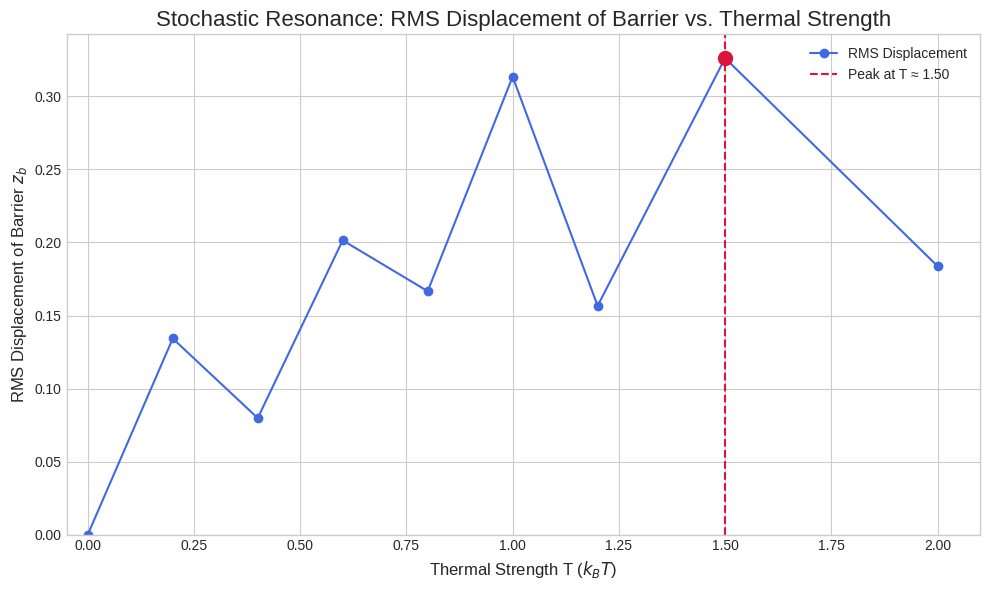

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ステップ6: 完了。『stochastic_resonance_rms.pdf』がダウンロードされました。

【全タスク完了】


In [1]:
# ===================================================================
# 【新生v4.0】Task2: 確率共鳴の定量的証拠の提示 (最終提出コード v2.1)
# 目的：熱ゆらぎ強度Tを掃引し、障壁のRMS変位を計算することで、
#       確率共鳴に特徴的なベル型カーブをプロットする。
# 生成物：
#   1. stochastic_resonance_rms.pdf (最終的なグラフ画像)
#   2. stochastic_resonance_data.csv (各温度での計算結果データ)
#   3. barrier_trajectory_data.csv (全シミュレーションの軌道データ)
# ===================================================================

# ステップ1：必要なライブラリのインストールとインポート
# -------------------------------------------------------------------
print("ステップ1: ライブラリのインストールとインポートを開始します...")
# 念のため、環境をクリーンアップしてからインストール
!pip uninstall -y cupy-cuda11x cupy-cuda12x > /dev/null 2>&1
!pip install cupy-cuda12x tqdm > /dev/null 2>&1

import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from google.colab import files
import warnings

# CuPyのUserWarningを抑制
warnings.filterwarnings("ignore", category=UserWarning, module="cupy")
print("ステップ1: 完了。")

# ステップ2：シミュレーションパラメータの設定
# -------------------------------------------------------------------
print("\nステップ2: シミュレーションパラメータを設定します...")

# --- 物理パラメータ (CPU側で定義) ---
L_np = np.array([32.0, 32.0, 128.0])
N_np = np.array([64, 64, 256])
dx_np = L_np / N_np

# --- GPU側に転送 ---
L = cp.asarray(L_np)
N = cp.asarray(N_np)
dx = cp.asarray(dx_np)

m = 1.0
hbar = 1.0
g = -15.0
omega_perp = 0.1
A = 0.1
sigma = 4.0
M = 50.0
k_mech = 10.0
zb0 = -20.0
gamma = 1.5 # 散逸係数は固定

# --- 時間発展のパラメータ ---
dt = 0.0005
t_max = 80.0 # 計算時間を延長
n_steps = int(t_max / dt)
analysis_start_step = int(40.0 / dt) # 解析開始ステップ (t=40以降)

# --- 初期状態のパラメータ ---
kz_kick = 0.15

# --- ★★★ 掃引するパラメータ ★★★ ---
kBT_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.5, 2.0]

print("ステップ2: 完了。")


# ステップ3：シミュレーション関数の定義
# -------------------------------------------------------------------
print("\nステップ3: シミュレーション関数を定義します...")

def run_simulation_for_sr(kBT):
    # --- 空間・波数グリッドの準備 ---
    x = cp.arange(-L_np[0]/2, L_np[0]/2, dx_np[0])
    y = cp.arange(-L_np[1]/2, L_np[1]/2, dx_np[1])
    z = cp.arange(-L_np[2]/2, L_np[2]/2, dx_np[2])
    X, Y, Z = cp.meshgrid(x, y, z, indexing='ij')

    kx = 2 * cp.pi * cp.fft.fftfreq(int(N_np[0]), d=dx_np[0])
    ky = 2 * cp.pi * cp.fft.fftfreq(int(N_np[1]), d=dx_np[1])
    kz = 2 * cp.pi * cp.fft.fftfreq(int(N_np[2]), d=dx_np[2])
    Kx, Ky, Kz = cp.meshgrid(kx, ky, kz, indexing='ij')
    K2 = Kx**2 + Ky**2 + Kz**2

    # --- 初期波動関数の設定 ---
    V_trap = 0.5 * m * omega_perp**2 * (X**2 + Y**2)
    mu = 0.42
    psi_real = cp.sqrt(cp.maximum(0, (mu - V_trap) / g))
    psi = psi_real.astype(cp.complex128)

    norm = cp.sqrt(cp.sum(cp.abs(psi)**2) * cp.prod(dx))
    psi /= norm
    psi *= cp.exp(1j * kz_kick * Z)

    # --- 古典場の初期化 ---
    zb = cp.array(zb0)
    vb = cp.array(0.0)

    # --- データ保存用配列 ---
    zb_trajectory = []

    exp_K = cp.exp(-1j * hbar * K2 * dt / (2 * m))

    # --- 時間発展ループ ---
    for i in range(n_steps + 1):
        V_barrier = A * cp.exp(-(Z - zb)**2 / (2 * sigma**2))
        V_total = V_trap + V_barrier
        psi *= cp.exp(-1j * (V_total + g * cp.abs(psi)**2) * dt / (2 * hbar))

        psi_k = cp.fft.fftn(psi)
        psi_k *= exp_K
        psi = cp.fft.ifftn(psi_k)

        psi *= cp.exp(-1j * (V_total + g * cp.abs(psi)**2) * dt / (2 * hbar))

        dV_dzb = (Z - zb) / sigma**2 * V_barrier
        F_feedback = -cp.sum(cp.abs(psi)**2 * dV_dzb).real * cp.prod(dx)
        F_restoring = -k_mech * (zb - zb0)
        F_thermal = cp.random.normal(0, cp.sqrt(2 * gamma * kBT / dt)) if kBT > 0 else cp.array(0.0)
        F_total_t = F_feedback + F_restoring - gamma * vb + F_thermal

        zb_new = zb + vb * dt + 0.5 * F_total_t * dt**2 / M

        V_barrier_new = A * cp.exp(-(Z - zb_new)**2 / (2 * sigma**2))
        dV_dzb_new = (Z - zb_new) / sigma**2 * V_barrier_new
        F_feedback_new = -cp.sum(cp.abs(psi)**2 * dV_dzb_new).real * cp.prod(dx)
        F_restoring_new = -k_mech * (zb_new - zb0)
        F_thermal_new = cp.random.normal(0, cp.sqrt(2 * gamma * kBT / dt)) if kBT > 0 else cp.array(0.0)

        F_total_t_plus_1 = F_feedback_new + F_restoring_new - gamma * vb + F_thermal_new

        vb_new = vb + 0.5 * (F_total_t + F_total_t_plus_1) * dt / M

        zb = zb_new
        vb = vb_new

        if i % 200 == 0: # 200ステップごとに記録
            zb_trajectory.append(zb.get())

    return np.array(zb_trajectory)

print("ステップ3: 完了。")


# ステップ4：掃引シミュレーションの実行とデータ収集
# -------------------------------------------------------------------
print(f"\nステップ4: {len(kBT_values)}点の温度で掃引シミュレーションを実行します。非常に時間がかかります...")

rms_results = []
all_trajectories = {}
time_points = np.arange(0, t_max + dt, dt * 200)

for kBT in tqdm(kBT_values, desc="温度掃引中"):
    # シミュレーション実行
    zb_traj = run_simulation_for_sr(kBT)
    all_trajectories[f'T_{kBT}'] = zb_traj

    # 定常状態に達した後半部分のデータで解析
    zb_steady_state = zb_traj[len(time_points[time_points < 40.0]):]

    # RMS変位の計算
    if len(zb_steady_state) > 1:
        mean_zb = np.mean(zb_steady_state)
        rms_zb = np.sqrt(np.mean((zb_steady_state - mean_zb)**2))
    else:
        rms_zb = 0.0

    rms_results.append({'T': kBT, 'RMS_Displacement': rms_zb})

print("ステップ4: 完了。")


# ステップ5：データフレームの作成とCSVファイルのエクスポート
# -------------------------------------------------------------------
print("\nステップ5: 結果をCSVファイルにまとめ、ダウンロードします...")

# RMS変位の結果
df_rms = pd.DataFrame(rms_results)
csv_rms_filename = 'stochastic_resonance_data.csv'
df_rms.to_csv(csv_rms_filename, index=False)
files.download(csv_rms_filename)
print(f"『{csv_rms_filename}』がダウンロードされました。")

# 全軌道データ
df_traj = pd.DataFrame(all_trajectories)
df_traj.insert(0, 'time', time_points)
csv_traj_filename = 'barrier_trajectory_data.csv'
df_traj.to_csv(csv_traj_filename, index=False)
files.download(csv_traj_filename)
print(f"『{csv_traj_filename}』がダウンロードされました。")

print("ステップ5: 完了。")


# ステップ6：グラフの作成とPDFファイルのエクスポート
# -------------------------------------------------------------------
print("\nステップ6: 確率共鳴のグラフを作成し、PDFファイルとしてダウンロードします...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# --- グラフ描画 ---
ax.plot(df_rms['T'], df_rms['RMS_Displacement'], marker='o', linestyle='-', color='royalblue', label='RMS Displacement')

# --- ピーク位置の特定と表示 ---
if not df_rms.empty:
    peak_idx = df_rms['RMS_Displacement'].idxmax()
    peak_T = df_rms.loc[peak_idx, 'T']
    peak_rms = df_rms.loc[peak_idx, 'RMS_Displacement']
    ax.axvline(peak_T, color='crimson', linestyle='--', label=f'Peak at T ≈ {peak_T:.2f}')
    ax.plot(peak_T, peak_rms, 'o', color='crimson', markersize=10)

# --- グラフタイトルと軸ラベル ---
ax.set_title('Stochastic Resonance: RMS Displacement of Barrier vs. Thermal Strength', fontsize=16)
ax.set_xlabel('Thermal Strength T ($k_B T$)', fontsize=12)
ax.set_ylabel('RMS Displacement of Barrier $z_b$', fontsize=12)
ax.legend()
ax.set_xlim(left=-0.05)
ax.set_ylim(bottom=0)

fig.tight_layout()

# PDFファイルとして保存
pdf_filename = 'stochastic_resonance_rms.pdf'
plt.savefig(pdf_filename, bbox_inches='tight')
plt.show()

# ダウンロード
files.download(pdf_filename)

print(f"ステップ6: 完了。『{pdf_filename}』がダウンロードされました。")
print("\n【全タスク完了】")